### libs

In [1]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

### Nets

In [2]:
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, channels):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.linear_layer = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_layers = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.linear_layer(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        image = self.conv_layers(out)
        return image


class Discriminator(nn.Module):
    def __init__(self, channels, img_size):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_layers = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # self.ds_size = img_size // 2 ** 4 # for img_size = 96
        self.ds_size = 2 # for img_size = 28
        self.adverse_layer = nn.Sequential(nn.Linear(128 * self.ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, image):
        out = self.conv_layers(image)
        out = out.view(out.shape[0], -1)
        validity = self.adverse_layer(out)
        return validity

### Helper

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [4]:
def ploter(corrupted_images, generated_images, original_images):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,3,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(corrupted_images)
    plt.tight_layout()
    plt.title("corrupted")

    plt.subplot(1,3,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(generated_images)
    plt.tight_layout()
    plt.title("generated")

    plt.subplot(1,3,3)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(original_images)
    plt.tight_layout()
    plt.title("original")

    plt.show()

In [5]:
def context_loss(corrupted_images, generated_images, masks, weighted=True):
    return torch.sum(((corrupted_images-generated_images)**2)*masks)

In [6]:
def get_weighted_mask(mask,window_size):
    assert len(mask.shape) == 3
    assert window_size % 2 == 1 # odd window size
    max_shift = window_size//2
    output = np.zeros_like(mask)
    for i in range(-max_shift,max_shift+1):
        for j in range(-max_shift,max_shift+1):
            if i != 0 or j != 0:
                output += np.roll(mask, (i,j), axis=(1,2))
    output = 1 - output/(window_size**2-1)
    return output*mask

### Dataset

In [7]:
root_ds = "./MNIST"

In [8]:
trans=transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5,) , (0.5,))
])

test_data=datasets.MNIST(root=root_ds,
                          train=False, transform=trans, download=True)

In [9]:
def get_index(class_num, dataset, mode:str):
    if mode == 'train':
        class_indx = torch.nonzero(
                dataset.train_labels == class_num * torch.ones_like(dataset.train_labels)
        )

    if mode == 'test':
        class_indx = torch.nonzero(
                dataset.test_labels == class_num * torch.ones_like(dataset.test_labels)
        )

    class_indx = class_indx.squeeze(1)
    return class_indx

In [10]:
test_sampler = SubsetRandomSampler(get_index(8, test_data, 'test'))
test_loader=DataLoader(test_data, batch_size= test_data.__len__(), sampler=test_sampler)

B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [34]:
def mask_maker(image_size):

    mask = np.ones(image_size,dtype=np.float32)
    x = np.random.randint(image_size[0]//6,5*image_size[0]//6)
    y = np.random.randint(image_size[1]//6,5*image_size[1]//6)
    h = np.random.randint(image_size[0]//4,image_size[0]//2)
    w = np.random.randint(image_size[1]//4,image_size[1]//2)
    mask[max(0,x-h//2):min(image_size[0],x+h//2),max(0,y-w//2):min(image_size[1],y+w//2)] = 0

    return mask

In [47]:
class CorruptedMaker(Dataset):
    def __init__(self, original_images, mask, image_size=(28,28), weighted_mask=True, window_size=7):
        super(CorruptedMaker, self).__init__()

        self.images_filename = original_images # (N, 1, 28, 28)
        self.image_size = image_size
        self.weighted_mask = weighted_mask
        self.window_size = window_size
        self.mask = mask

    def __len__(self):
        return len(self.images_filename)

    def __getitem__(self, idx):
        original_image = self.images_filename[idx]

        target_image = original_image.copy()

        #target_image[0][1-self.mask > 0.5] = np.max(target_image)
        target_image[0] =  target_image[0]* self.mask

        mask = self.mask.reshape((1,)+self.mask.shape)

        # Weighted Mask
        if self.weighted_mask:
            weighted_mask = get_weighted_mask(mask,self.window_size)
            return torch.FloatTensor(target_image), torch.FloatTensor(original_image), torch.FloatTensor(mask), torch.FloatTensor(weighted_mask)
        else:
            return torch.FloatTensor(target_image), torch.FloatTensor(original_image), torch.FloatTensor(mask)

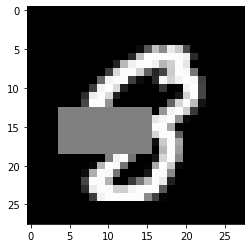

In [48]:
# TEST
image_size = (28, 28)

for x, _ in test_loader:
    x=x

mask = mask_maker(image_size)
dataset = CorruptedMaker(x[0:1].numpy(), mask, image_size)
dataloader = DataLoader(dataset, batch_size=1)

for corrupted_images, original_images, masks, weighted_masks in dataloader:
    corrupted_images = corrupted_images
    original_images = original_images
    masks = masks
    weighted_masks = weighted_masks
plt.imshow(corrupted_images[0][0], cmap='gray')

In [49]:
mask == (corrupted_images/original_images)[0][0].numpy()

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True

### Hyperparameters

In [50]:
os.getcwd()

'F:\\GitHub\\anomaly-detection\\codes\\inpairing_cvpr\\benchmark'

In [51]:
root_best_model = "epoch220_disloss24.18_genloss52.93.pt"

window_size = 25 #??
batch_size = 1
num_sub = 1

img_size = 28
latent_dim = 100
channels = 1

optim_steps = 1000 # ???
sample_interval = 100

prior_weight = 0.003 # ???

### inpainting

In [57]:
for x, _ in test_loader:
    x=x

In [58]:
mask = mask_maker(image_size)
dataset = CorruptedMaker(x[0:num_sub].numpy(), mask, image_size, weighted_mask=True, window_size=25)
dataloader = DataLoader(dataset, batch_size=batch_size)

In [59]:
# Loading trained GAN model
saved_gan = torch.load(root_best_model)

generator = Generator(img_size=img_size, latent_dim=latent_dim, channels=channels).cuda()
discriminator = Discriminator(channels=channels, img_size=img_size).cuda()

generator.load_state_dict(saved_gan["state_dict_G"])
discriminator.load_state_dict(saved_gan["state_dict_D"])

<All keys matched successfully>

In [60]:
z_optimum = nn.Parameter(torch.FloatTensor(np.random.normal(0, 1, (batch_size,latent_dim,))).cuda())
optimizer_inpaint = optim.Adam([z_optimum], lr=0.1)

In [ ]:
for i, (corrupted_images, original_images, masks, weighted_masks) in enumerate(dataloader):
    corrupted_images, masks, weighted_masks = corrupted_images.cuda(), masks.cuda(), weighted_masks.cuda()

    print("Starting backprop to input ...")
    for epoch in range(optim_steps):

        optimizer_inpaint.zero_grad()

        generated_images = generator(z_optimum)
        discriminator_opinion = discriminator(generated_images)

        c_loss = context_loss(corrupted_images, generated_images, weighted_masks)

        prior_loss = torch.sum(-torch.log(discriminator_opinion))
        inpaint_loss = c_loss #+ prior_weight*prior_loss
        inpaint_loss.backward()
        optimizer_inpaint.step()
        print("[Epoch: {}/{}] \t[Loss: \t[Context: {:.3f}] \t[Prior: {:.3f}] \t[Inpaint: {:.3f}]]  \r".format(1+epoch, optim_steps, c_loss,
                                                                           prior_loss, inpaint_loss),end="")
        if epoch % sample_interval ==0:
            # show a sample from generator
            num_rnd = math.floor(np.random.uniform(0, corrupted_images.shape[0]))
            ploter(corrupted_images[num_rnd,0].detach().cpu(),
                   generated_images[num_rnd,0].detach().cpu(),
                   original_images[num_rnd,0].detach().cpu())
    #blended_images = posisson_blending(masks, generated_images.detach(), corrupted_images)

Starting backprop to input ...


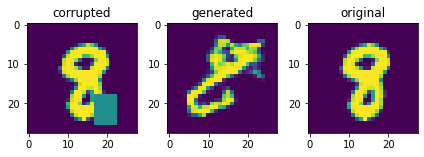

[Epoch: 20/1000] 	[Loss: 	[Context: 6.292] 	[Prior: 6.026] 	[Inpaint: 6.292]]  [Epoch: 46/1000] 	[Loss: 	[Context: 2.359] 	[Prior: 7.833] 	[Inpaint: 2.359]]  [Epoch: 70/1000] 	[Loss: 	[Context: 1.392] 	[Prior: 5.908] 	[Inpaint: 1.392]]  [Epoch: 94/1000] 	[Loss: 	[Context: 1.075] 	[Prior: 5.341] 	[Inpaint: 1.075]]  

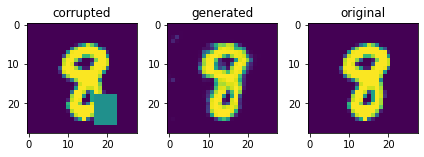

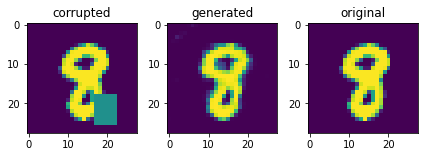

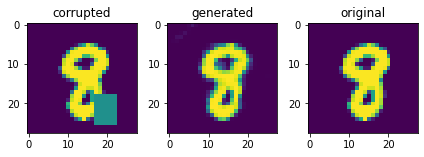

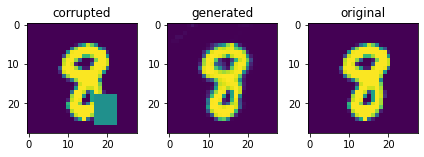

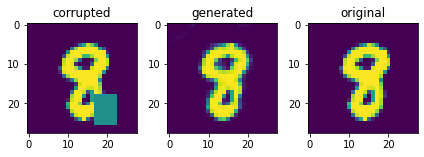

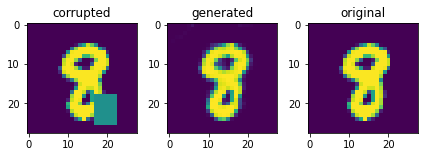

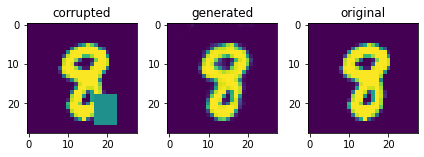

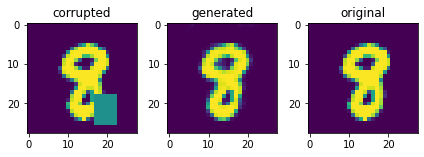

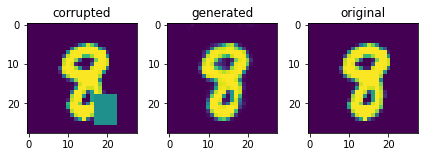

In [61]:
for i, (corrupted_images, original_images, masks, weighted_masks) in enumerate(dataloader):
    corrupted_images, masks, weighted_masks = corrupted_images.cuda(), masks.cuda(), weighted_masks.cuda()

    print("Starting backprop to input ...")
    for epoch in range(optim_steps):

        optimizer_inpaint.zero_grad()

        generated_images = generator(z_optimum)
        discriminator_opinion = discriminator(generated_images)

        c_loss = context_loss(corrupted_images, generated_images, weighted_masks)

        prior_loss = torch.sum(-torch.log(discriminator_opinion))
        inpaint_loss = c_loss #+ prior_weight*prior_loss
        inpaint_loss.backward()
        optimizer_inpaint.step()
        print("[Epoch: {}/{}] \t[Loss: \t[Context: {:.3f}] \t[Prior: {:.3f}] \t[Inpaint: {:.3f}]]  \r".format(1+epoch, optim_steps, c_loss,
                                                                           prior_loss, inpaint_loss),end="")
        if epoch % sample_interval ==0:
            # show a sample from generator
            num_rnd = math.floor(np.random.uniform(0, corrupted_images.shape[0]))
            ploter(corrupted_images[num_rnd,0].detach().cpu(),
                   generated_images[num_rnd,0].detach().cpu(),
                   original_images[num_rnd,0].detach().cpu())
    #blended_images = posisson_blending(masks, generated_images.detach(), corrupted_images)

In [45]:
corrupted_images - generated_images

tensor([[[[-1.4544e-05, -1.0729e-06, -7.1526e-07, -9.5367e-07, -7.0930e-06,
           -1.5438e-05, -4.5300e-05, -6.9678e-05, -1.0431e-05, -8.8215e-06,
           -3.1590e-06, -1.0729e-06, -4.5896e-06, -1.5545e-04, -3.2866e-04,
           -2.4545e-04, -6.3777e-06, -1.1921e-07,  0.0000e+00, -5.9605e-08,
           -5.0068e-06, -3.2574e-04, -8.3849e-03, -4.1308e-02, -3.6082e-03,
           -6.7830e-05, -3.8147e-06, -1.8299e-05],
          [-5.9605e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00, -2.9802e-07, -4.5300e-06, -5.3644e-07,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00, -5.9605e-08,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           -1.1325e-06, -2.2531e-05, -5.5778e-04, -1.5045e-03, -1.7643e-05,
           -5.9605e-08,  0.0000e+00, -5.9605e-08],
          [-8.9407e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.9605e-08,
           -7.7486e-07, -2.0206e-05, -4.7457e-04, -2.1160e-05,

In [66]:
def back_mask(corrupted_images, generated_images, threshold=0.9):
    mask_ = corrupted_images/generated_images
    mask = 1-mask_
    mask [mask<threshold] = 0
    #a = (corrupted_images - generated_images).abs()
    mask = 1-mask
    return mask

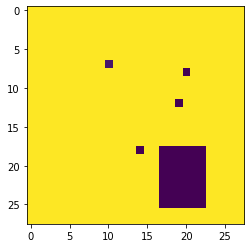

In [67]:
mask = back_mask(corrupted_images, generated_images)
plt.imshow(mask[0][0].detach().cpu(), vmin=0, vmax=1)

In [65]:
mask[0,0,15:, 15:]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0',
       grad_fn=<SliceBackward0>)